# Slate Star Codex Reader Survey 2018

**If you enjoy this, let's connect on LinkedIn:**

**https://www.linkedin.com/in/vincefavilla/**

I'm a psychology professor and machine learning engineer. Also, I'm in the SF Bay Area and looking for a job outside of academia. :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


After some experimenting, I decided that it's better to analyze the data where I inferred the missing values using machine learning. This obviously isn't perfect, and we can't be certain what someone *would have* answered, but we can more accurately represent individual differences this way.

In [2]:
data = pd.read_csv('ssc2018public_inferred.csv')

data = data[[i for i in data.columns if 'Unnamed' not in i]]

print('Data has', data.shape[0], 'responses and', data.shape[1], 'features')

Data has 7260 responses and 838 features


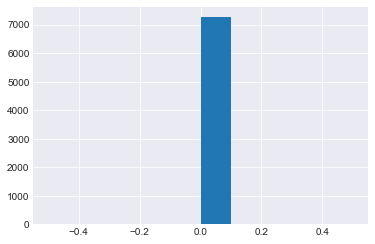

In [3]:
data['Num_missing'] = data.isnull().sum(axis=1)

data['Num_missing'].hist()

data = data[data.Num_missing < 20]

# Demographics

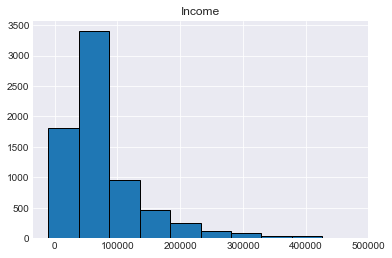

In [4]:
# Income
data[data.Income < 500000].Income.hist(edgecolor='black') # Remove the millionaire outliers
plt.title('Income')

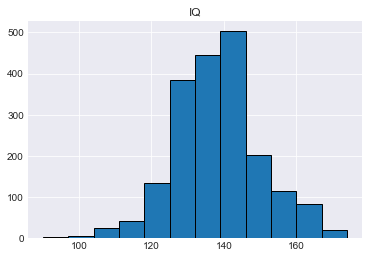

In [5]:
# IQ
data[data.IQ != data.IQ.median()].IQ.hist(edgecolor='black', bins=12)

plt.title('IQ')

We can normalize the SAT scores to account for which version of the test people took. We have a lot of really smart people in this community.

As a side note, whenever you see code along the lines of `!= .median()`, it means I'm removing the missing data I couldn't reasonably predict.

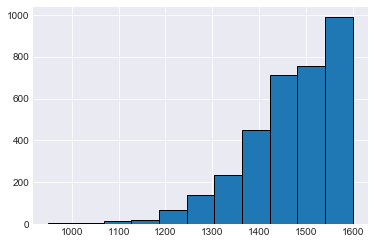

In [6]:
sat = np.where(data.SATscoresoutof1600 != data.SATscoresoutof1600.median(), data.SATscoresoutof1600/1600, np.nan)
sat = np.where(data.SATscoresoutof2400 != data.SATscoresoutof2400.median(), data.SATscoresoutof2400/2400, sat)

sat = pd.Series(sat) * 1600

sat[sat > 900].hist(edgecolor='black', bins=11)

One of my favorite things about the rationalist community is we tend to assume we're average unless we have strong evidence otherwise...

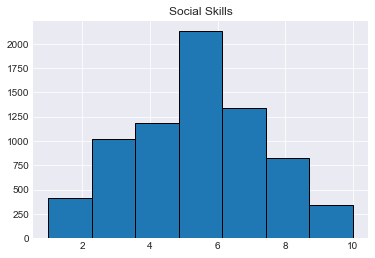

In [7]:
data.SocialSkills.hist(edgecolor='black', bins=7)
plt.title('Social Skills')

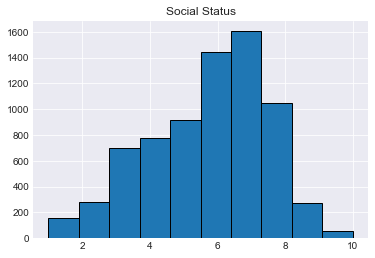

In [8]:
data.Status.hist(edgecolor='black', bins=10)
plt.title('Social Status')

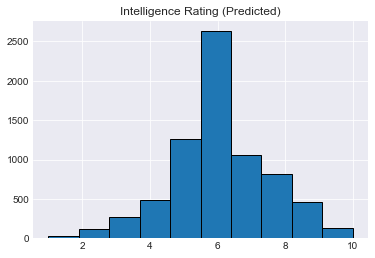

In [9]:
# "How intelligent do you think you are compared to the average reader of this blog?"
data.Percentile.hist(edgecolor='black', bins=10)
# I replaced missing values with the median -- and kept it -- 
# so this graph is a little more peaky than the others.

plt.title('Intelligence Rating (Predicted)')

Let's graph IQ vs. how people think they stack up against fellow SSC readers.

Correlation: 0.254


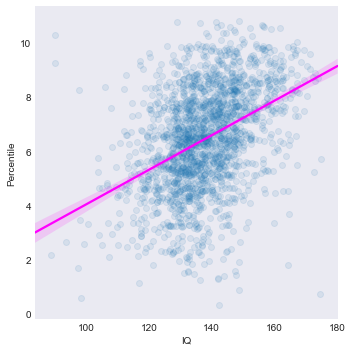

In [10]:
print('Correlation:', round(np.corrcoef(data.Percentile, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Percentile', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

The Dunning-Kruger effect is in full force in the top left. They're probably trolls. There are also a handful of very underconfident geniuses.

The relationship between IQ and social status is not as pronounced...

Correlation: 0.105


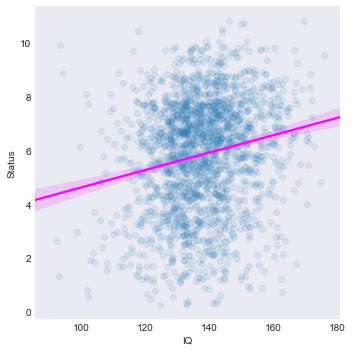

In [11]:
print('Correlation:', round(np.corrcoef(data.Status, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Status', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

# Life Outcomes

Let's look at the correlates for:

- RomanticLife
- FinancialSituation & Income
- LifeSatisfaction & MoodScale

The usual warning of correlation does not equal causation applies.

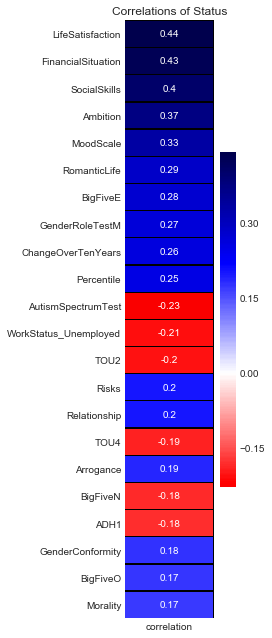

In [12]:
def absolute_correlations(col, df=data, ascending=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    else:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)

def corrmap(df, cutoff=0.2, title='Correlations'):
    top_corrs = df[abs(df.correlation) > cutoff]
    plt.figure(figsize=(2,len(top_corrs)//2))
    plt.title(title)
    sns.heatmap(top_corrs, annot=True, fmt='.2g', cmap='seismic_r',
                center=0, linecolor='black', linewidths=.25)

# Status
status = absolute_correlations('Status', ascending=False)
corrmap(status, cutoff=.17, title='Correlations of Status')

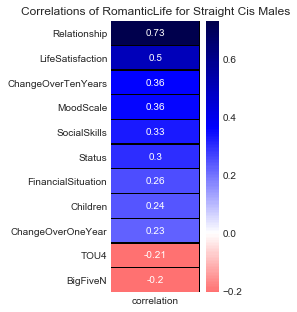

In [13]:
# Romantic life for straight cis males
scm = data[(data['Gender_M (cisgender)'] == 1) & (data['SexualOrientation_Heterosexual']) & (data['Sex_Male'] == 1)]

status = absolute_correlations('RomanticLife', df=scm, ascending=False)
corrmap(status, cutoff=.20, title='Correlations of RomanticLife for Straight Cis Males')

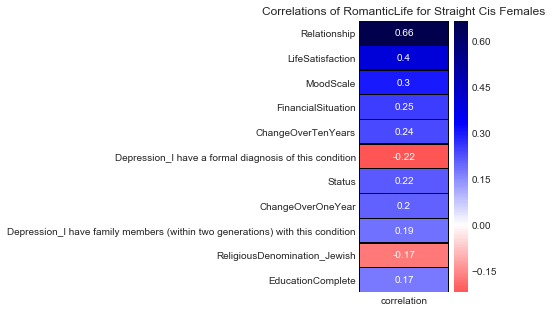

In [14]:
# Romantic life for straight cis females
scf = data[(data['Gender_F (cisgender)'] == 1) & data['SexualOrientation_Heterosexual'] & (data['Sex_Female'] == 1)]

status = absolute_correlations('RomanticLife', df=scf, ascending=False)
corrmap(status, cutoff=.17, title='Correlations of RomanticLife for Straight Cis Females')

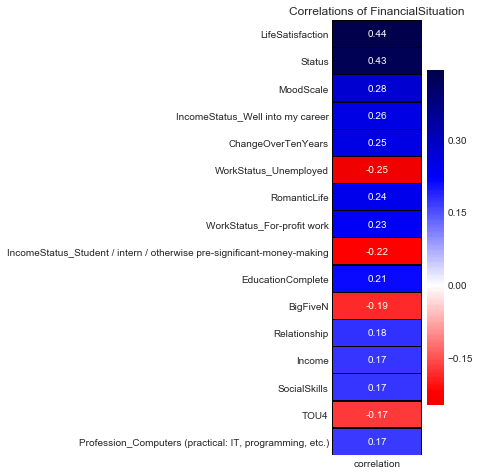

In [15]:
# FinancialSituation
finances = absolute_correlations('FinancialSituation', ascending=False)
corrmap(finances, cutoff=.17, title='Correlations of FinancialSituation')

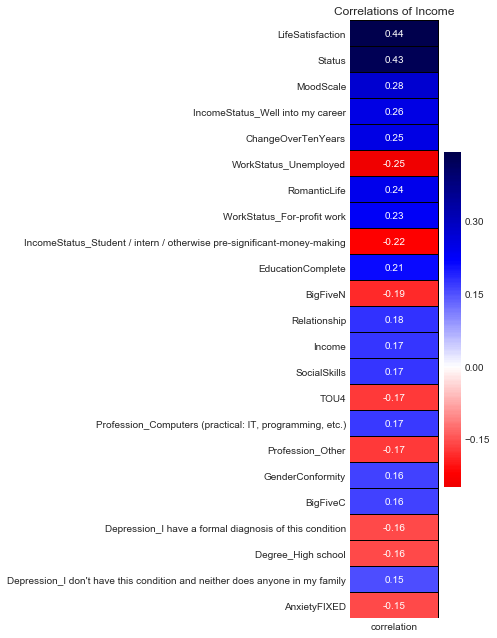

In [16]:
# Income

# This is a power law distribution so we should take the log
data['Log_income'] = np.log1p(data['Income'])

income = absolute_correlations('Log_income', df=data, ascending=False)
corrmap(finances, cutoff=.15, title='Correlations of Income')

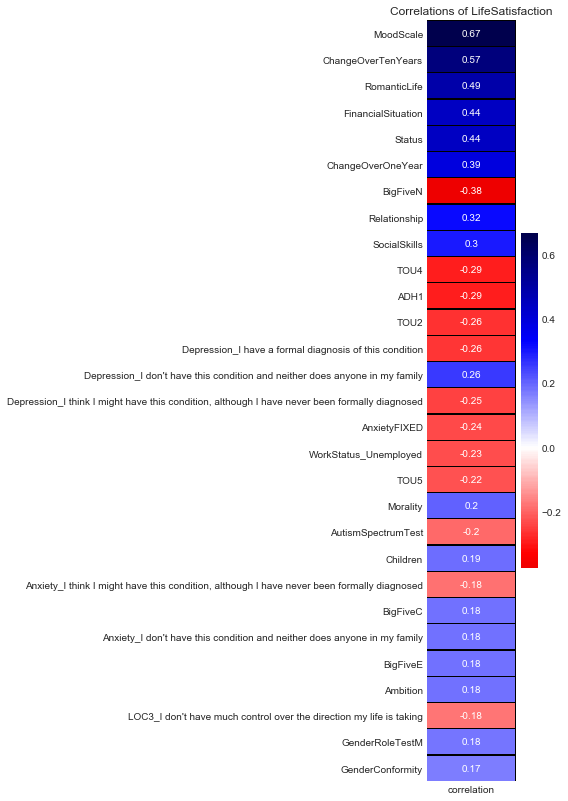

In [17]:
# LifeSatisfaction
satisfaction = absolute_correlations('LifeSatisfaction', ascending=False)
corrmap(satisfaction, cutoff=.17, title='Correlations of LifeSatisfaction')

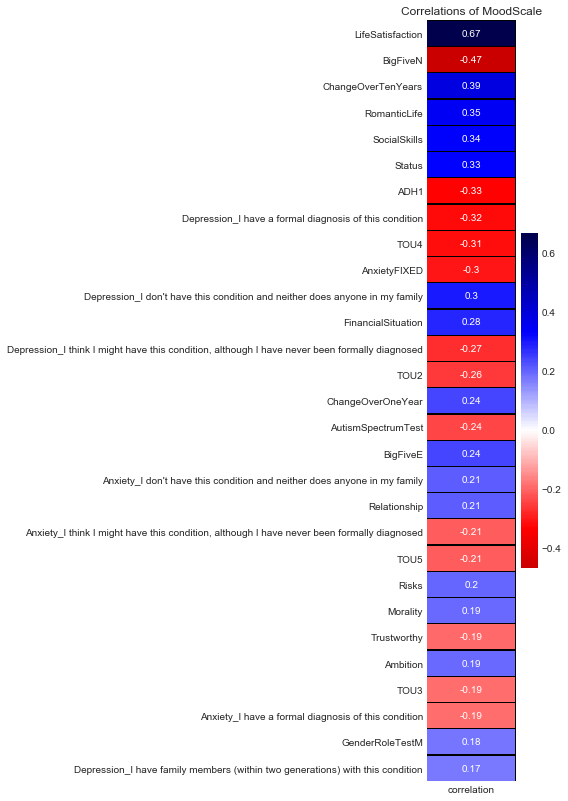

In [18]:
# MoodScale
mood = absolute_correlations('MoodScale', ascending=False)
corrmap(mood, cutoff=.17, title='Correlations of MoodScale')

# Personality

I think kdeplots look a bit better than histograms for graphing the big five personality traits. The distributions are a bit wonky, but a kdeplot can smooth them out and give us a better idea of what the population probably looks like.

In [19]:
men = data[data['Gender_M (cisgender)'] == 1]
women = data[data['Gender_F (cisgender)'] == 1]

print(men.shape[0], 'men and', women.shape[0], 'women')

6330 men and 653 women


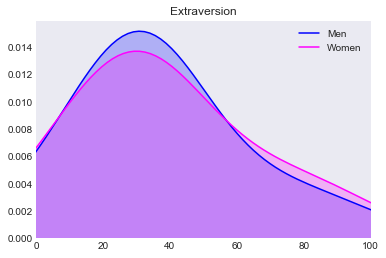

In [20]:
# No gender difference
sns.kdeplot(men['BigFiveE'], bw=18, color='blue', shade=True)
sns.kdeplot(women['BigFiveE'], bw=18, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Extraversion')

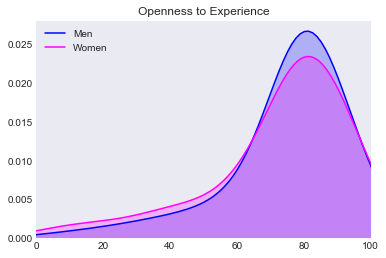

In [21]:
# No gender difference
sns.kdeplot(men['BigFiveO'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveO'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Openness to Experience')

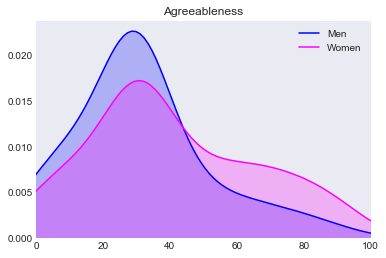

In [22]:
# Big difference here
sns.kdeplot(men['BigFiveA'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveA'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Agreeableness')

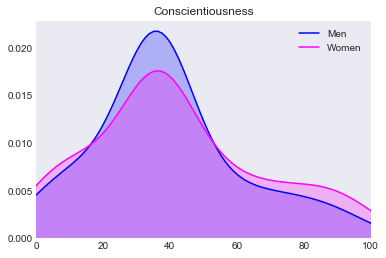

In [23]:
# It looks like women score higher here, and often they do,
# but we're also using scores predicted by machine learning

sns.kdeplot(men['BigFiveC'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveC'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Conscientiousness')

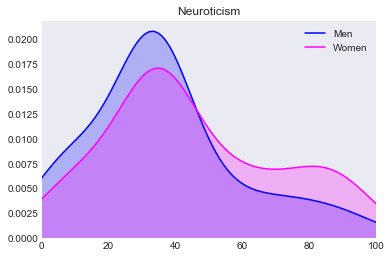

In [24]:
sns.kdeplot(men['BigFiveN'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveN'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Neuroticism')

Women do tend to score higher than men on neuroticism, but the bimodal distribution is odd.

# Religion

I've done a lot of religious/geographic analysis in the past and it's usually not that interesting because the differences tend to be pretty small. This dataset is no exception, but I'll include it since I'm sure lots of people are curious.

In [25]:
# When performing comparisons, it's better to not use inferred values
data = pd.read_csv('ssc2018public_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

In [26]:
# Converting religion back into a categorical variable
rels = data[[i for i in data.columns if "Denom" in i]].copy()

atheists = data[[i for i in data.columns if 'Ath' in i and 'but spiritual' not in i]].sum(axis=1)
rels['ReligiousDenomination_Atheist'] = pd.Series(np.where(atheists >= 1, 1., 0)).copy()
rels['ReligiousDenomination_Other'] = pd.Series(np.where(atheists >= 1, 0, rels['ReligiousDenomination_Other'])).copy()

rels = rels.idxmax(axis=1)

rels_vcs = rels.value_counts()
rels_vcs = rels_vcs[rels_vcs > 10]

rels = np.where(rels.isin(rels_vcs.index), rels, 'ReligiousDenomination_Other')

data['Religion_categorial'] = pd.Series(rels)

data['Religion_categorial'].value_counts()

ReligiousDenomination_Atheist                                                  4007
ReligiousDenomination_Other                                                    1554
ReligiousDenomination_Christian (Protestant)                                    634
ReligiousDenomination_Christian (Catholic)                                      362
ReligiousDenomination_Jewish                                                    213
ReligiousDenomination_Buddhist                                                  113
ReligiousDenomination_Mixed/Other                                               107
ReligiousDenomination_Unitarian Universalism Or Similar                          82
ReligiousDenomination_Christian (Other Non-Protestant, Eg Eastern Orthodox)      72
ReligiousDenomination_Christian (Mormon)                                         53
ReligiousDenomination_Hindu                                                      41
ReligiousDenomination_Quaker                                                

The average life satisfaction of different religions...

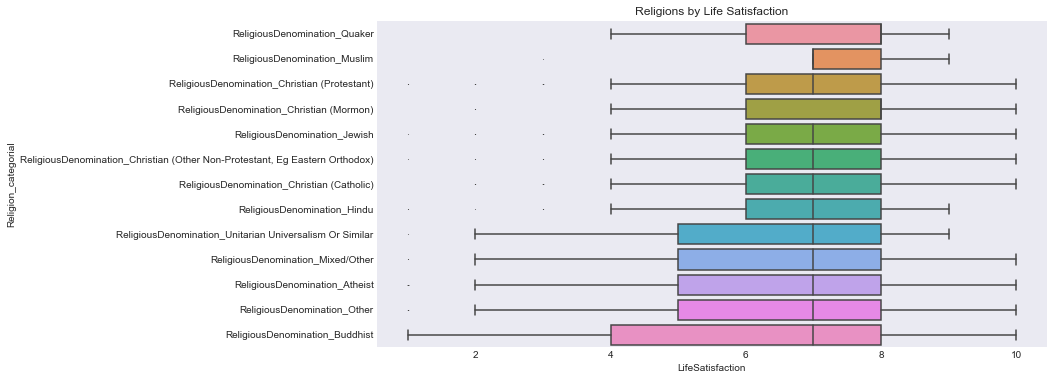

In [27]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').mean()['LifeSatisfaction'].sort_values(ascending=False).index
sns.boxplot(data['LifeSatisfaction'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Life Satisfaction')

In [28]:
# Comparing life satisfaction with a t-test
from scipy.stats import ttest_ind

def compare_top_and_bottom(col, order, top=0, bot=-1):
    df = data[data[col].notnull()]
    top_ix = order[top]
    bot_ix = order[bot]
    by = order.name
    
    if top == 0 and bot == -1:
        print('Highest ' + col + ': ' + top_ix)
        print('Lowest ' + col + ': ' + bot_ix)
    else:
        print('Comparing {} and {}'.format(top_ix, bot_ix))
    
    ttest = ttest_ind(df[df[by] == top_ix][col],
                      df[df[by] == bot_ix][col])
    return ttest
    
compare_top_and_bottom('LifeSatisfaction', order)

Highest LifeSatisfaction: ReligiousDenomination_Quaker
Lowest LifeSatisfaction: ReligiousDenomination_Buddhist


Ttest_indResult(statistic=1.2828635678820883, pvalue=0.20207540803630994)

There is **not** a statistically significant difference between the happiest religion (Quakers) and the unhappiest (Buddhists). I expected this, since Buddhists usually place first in happiness in other datasets I've looked at.

### Religions by Extraversion

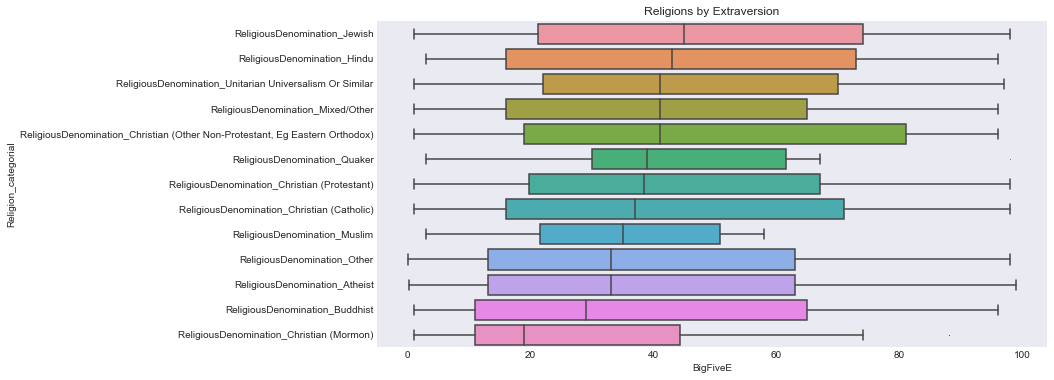

In [29]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveE'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveE'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Extraversion')

In [30]:
# Statistically significant
compare_top_and_bottom('BigFiveE', order)

Highest BigFiveE: ReligiousDenomination_Jewish
Lowest BigFiveE: ReligiousDenomination_Christian (Mormon)


Ttest_indResult(statistic=2.9761467858892279, pvalue=0.0034478008717579072)

### Religions by Openness to Experience

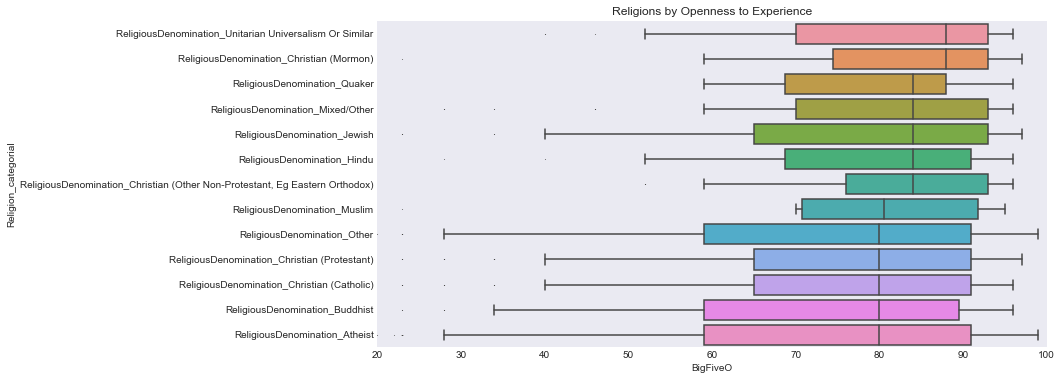

In [31]:
plt.figure(figsize=(12,6))
plt.xlim(20,100)

order = data.groupby('Religion_categorial').median()['BigFiveO'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveO'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Openness to Experience')

In [32]:
compare_top_and_bottom('BigFiveO', order)

Highest BigFiveO: ReligiousDenomination_Unitarian Universalism Or Similar
Lowest BigFiveO: ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.7152239692148843, pvalue=0.0066688904204366874)

So, SSC atheists are less open than Unitarians, which isn't all that surprising. But are they less open than, say, Protestants?

In [33]:
data_o = data[data.BigFiveO.notnull()]
ttest_ind(data_o[data_o['Religion_categorial'] == 'ReligiousDenomination_Christian (Protestant)']['BigFiveO'],
          data_o[data_o['Religion_categorial'] == 'ReligiousDenomination_Atheist']['BigFiveO'])

# Answer: Yes. SSC atheists score low in openness compared to other beliefs.

Ttest_indResult(statistic=2.1880336392866266, pvalue=0.028749066130254224)

### Religions by Agreeableness

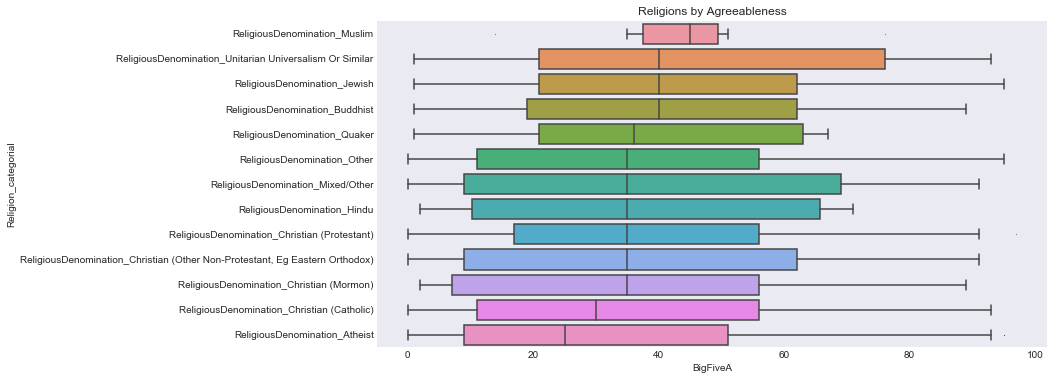

In [34]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveA'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveA'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Agreeableness')

In [35]:
compare_top_and_bottom('BigFiveA', order, top=-2)

Comparing ReligiousDenomination_Christian (Catholic) and ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.0208807953734151, pvalue=0.043392675096182519)

SSC atheists are extremely disagreeable, on average. Even comparing them to the 2nd-most disagreeable group, Catholics, there's still a significant difference.

### Religions by Neuroticism

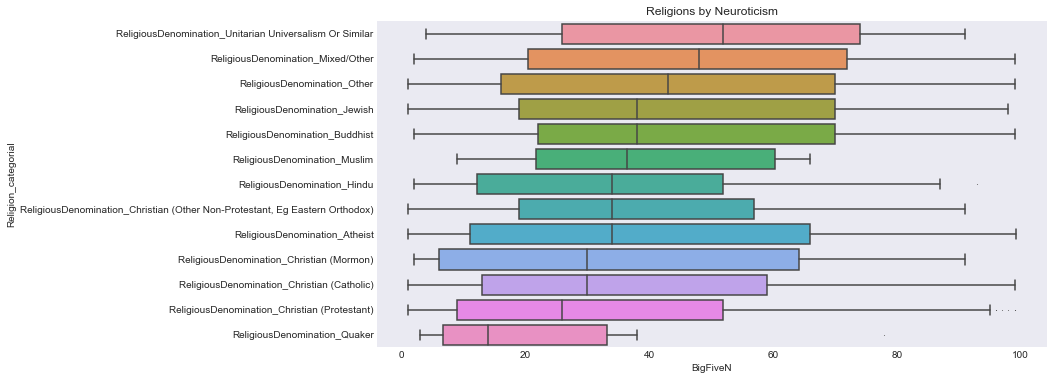

In [36]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveN'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveN'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Neuroticism')

Perhaps atheists should become Buddhist for their own mental health?

In [37]:
compare_top_and_bottom('BigFiveN', order, top=-9, bot=-5)

Comparing ReligiousDenomination_Buddhist and ReligiousDenomination_Atheist


Ttest_indResult(statistic=1.8430560324812235, pvalue=0.0654389533846787)

You could make a good argument for it.

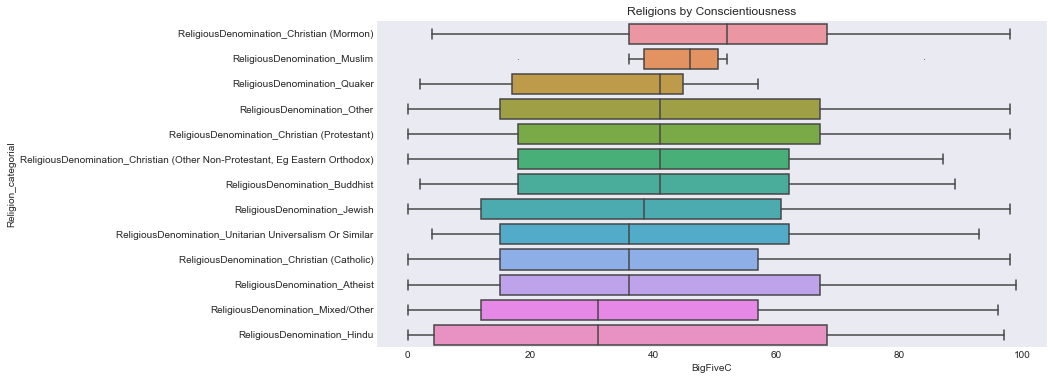

In [38]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveC'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveC'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Conscientiousness')

In [39]:
# Looks like the Mormon work ethic beats out the Protestant!
compare_top_and_bottom('BigFiveC', order, bot=4)

Comparing ReligiousDenomination_Christian (Mormon) and ReligiousDenomination_Christian (Protestant)


Ttest_indResult(statistic=1.666676460460965, pvalue=0.09635958014733155)

# Big Five Correlations

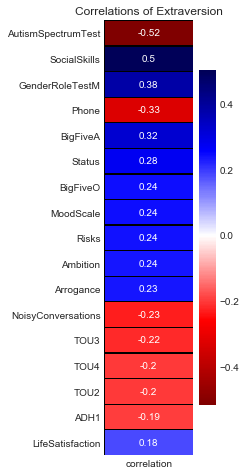

In [40]:
trait = absolute_correlations('BigFiveE', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Extraversion')

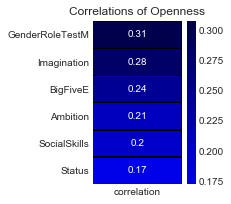

In [41]:
trait = absolute_correlations('BigFiveO', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Openness')

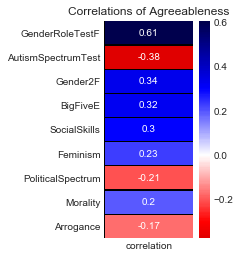

In [42]:
trait = absolute_correlations('BigFiveA', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Agreeableness')

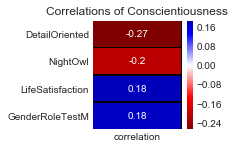

In [43]:
trait = absolute_correlations('BigFiveC', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Conscientiousness')

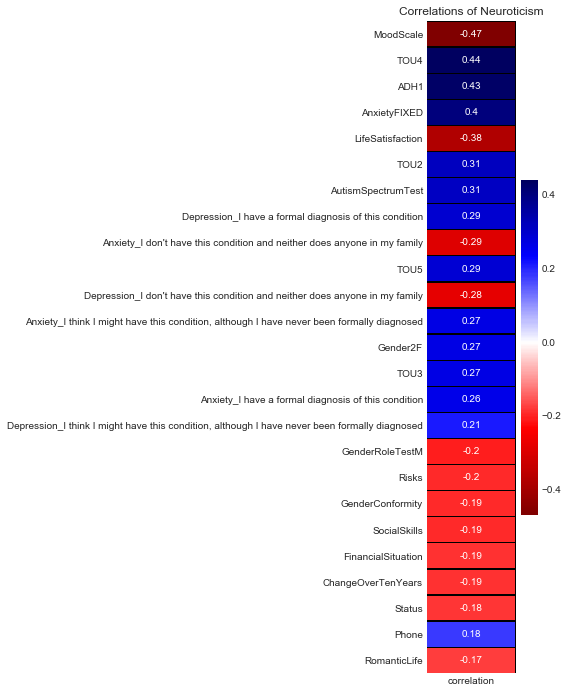

In [44]:
trait = absolute_correlations('BigFiveN', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Neuroticism')

# Correlation Matrix

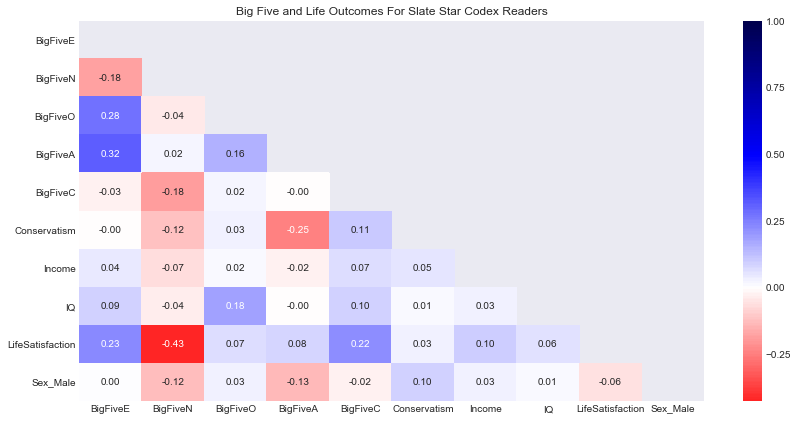

In [45]:
traits = data[['BigFiveE', 'BigFiveN', 'BigFiveO', 'BigFiveA', 'BigFiveC',
               'PoliticalSpectrum', 'Income', 'IQ', 'LifeSatisfaction', 'Sex_Male']]

# Clarifying and renaming PoliticalSpectrum
traits.rename(columns = {'PoliticalSpectrum':'Conservatism'}, inplace=True)

mask = np.zeros_like(traits.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14,7))
sns.heatmap(traits.corr(), annot=True, fmt='.2f', center=0, mask=mask, cmap='seismic_r')
plt.title('Big Five and Life Outcomes For Slate Star Codex Readers')

# Politics

Disclaimer: I'm pretty liberal, but I tried my best not to inject my opinions here and let the data speak for itself!

In [46]:
def three_pt_scale(col):
    scale = np.zeros_like(data)
    scale = np.where(data[col] > 3, 'Favorable', np.nan)
    scale = np.where(data[col] == 3, 'Neutral', scale)
    scale = np.where(data[col] < 3, 'Unfavorable', scale)
    return pd.Series(scale[scale != 'nan'])

trump = three_pt_scale('DonaldTrump')
bernie = three_pt_scale('BernieSanders')

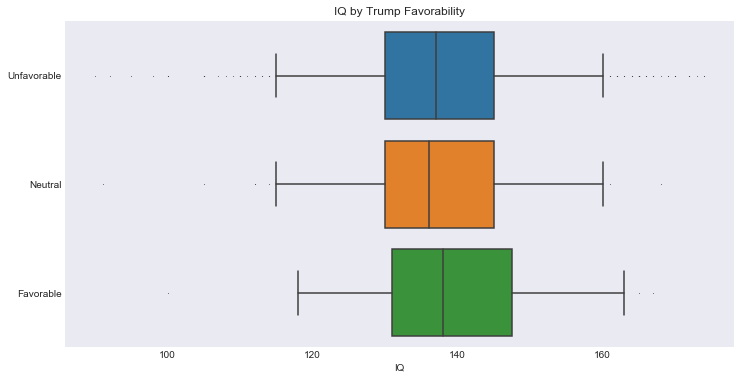

In [47]:
plt.figure(figsize=(12,6))

sns.boxplot(data['IQ'], trump, whis=1, orient='h', fliersize=.2)
plt.title('IQ by Trump Favorability')

In [48]:
data['TrumpFavorability'] = trump

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.TrumpFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.TrumpFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.8488017188320107, pvalue=0.064651806991960006)

In [49]:
data['BernieFavorability'] = bernie

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.BernieFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.BernieFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.3684855618753464, pvalue=0.17138143510670215)

SSC Trump supporters appear to be more intelligent, on average. Go figure.

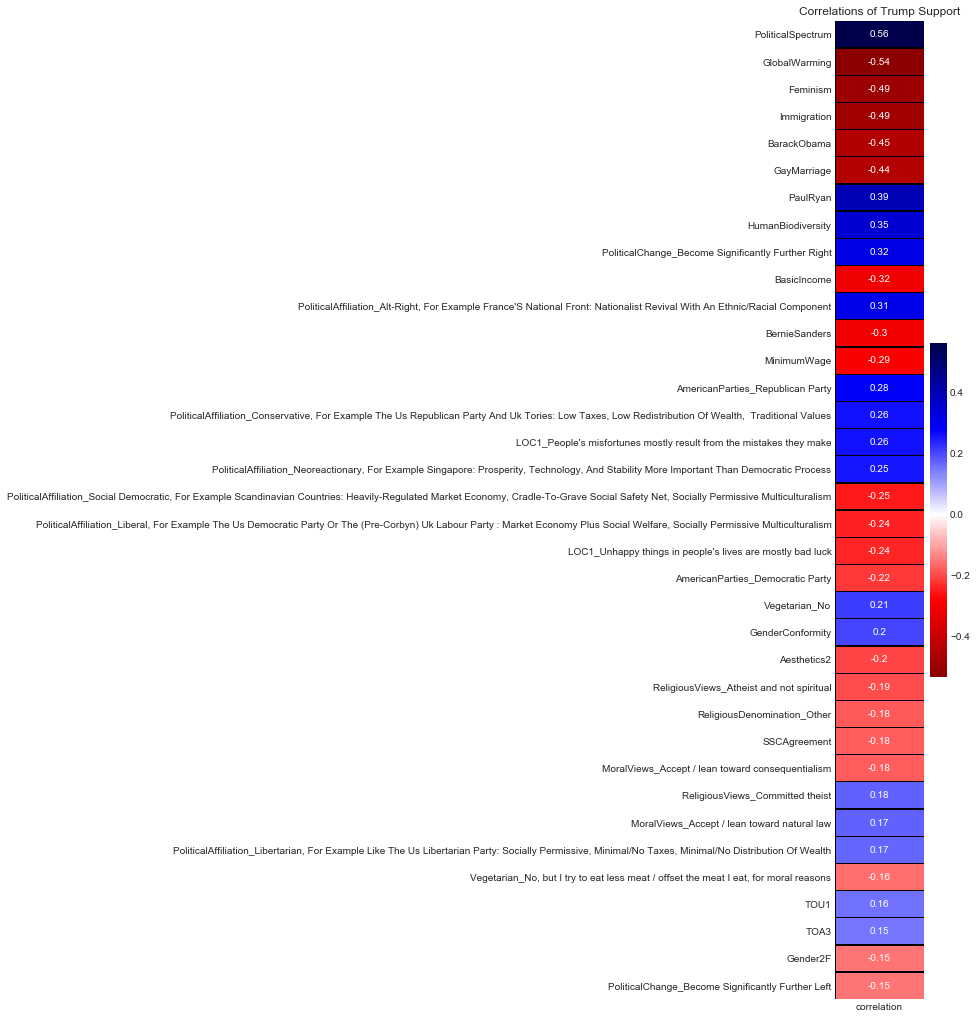

In [50]:
# Correlations of Trump Support
tr = absolute_correlations('DonaldTrump', ascending=False)
corrmap(tr, cutoff=.15, title='Correlations of Trump Support')

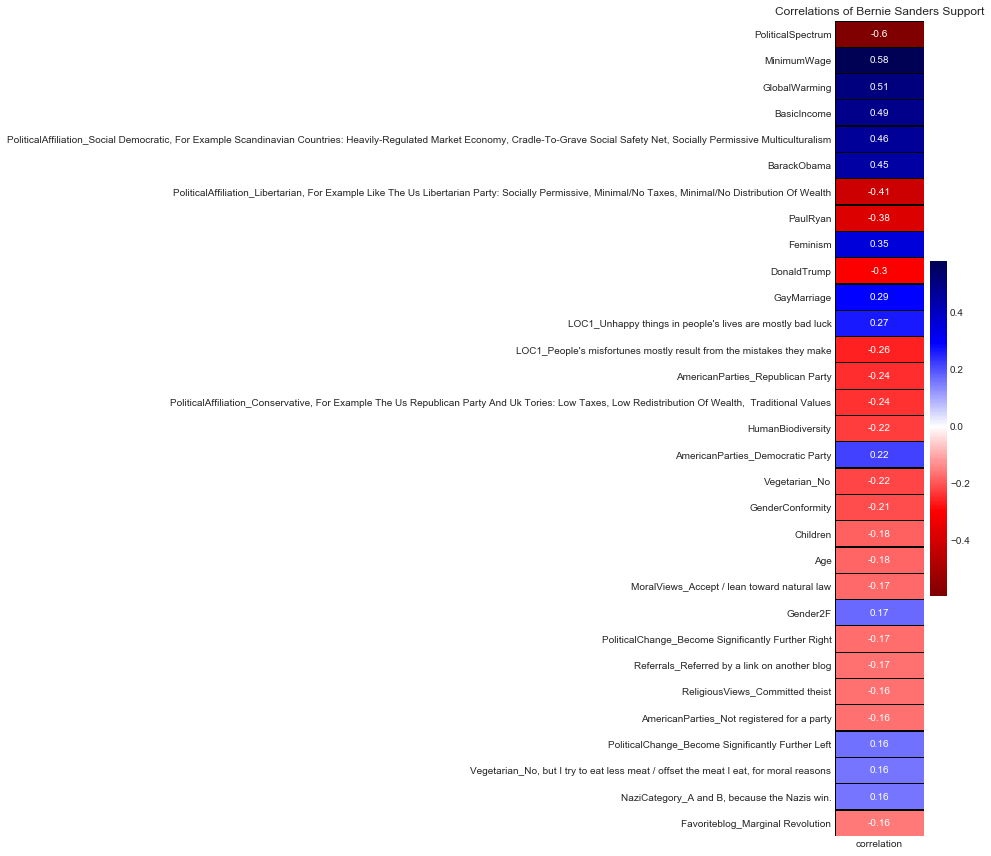

In [51]:
# Correlations of Bernie Sanders Support
bern = absolute_correlations('BernieSanders', ascending=False)
corrmap(bern, cutoff=.15, title='Correlations of Bernie Sanders Support')

So, are Trump supporters really more intelligent? This would be surprising. Openness to experience predicts IQ, and it's also correlated with liberal political beliefs.

Let's try something different. Let's try to infer IQ based *not* on what someone reports, but how they answer questions (particularly riddles) that correlate with IQ.

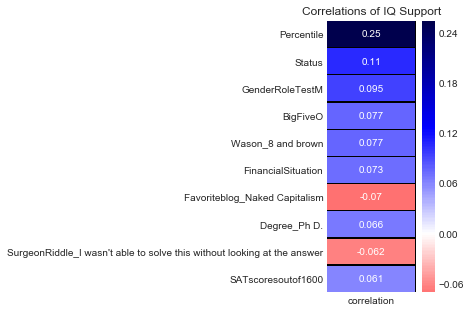

In [52]:
iq = absolute_correlations('IQ', ascending=False)
corrmap(iq, cutoff=.06, title='Correlations of IQ Support')

I chose to define "hidden IQ" with the following features. It can still be faked, but it's a little harder to.

In [53]:
data['HiddenIQ'] = (data['BigFiveO']/100 + data['Wason_8 and brown'] +
                  (1 - data['SurgeonRiddle_I wasn\'t able to solve this without looking at the answer']) +
                  data['SATscoresoutof1600'].fillna(data['SATscoresoutof1600'].mean()))/1600

(Fun fact: Removing openness from this actually *strengthens* the following correlations.)

In [54]:
from scipy import stats

t_iq = stats.pearsonr(data['HiddenIQ'].fillna(data['HiddenIQ'].median()),
               data['DonaldTrump'].fillna(data['DonaldTrump'].median()))

print('Donald Trump')
print('Correlation:\t', t_iq[0])
print('p-value:\t', t_iq[1])

Donald Trump
Correlation:	 -0.036498154289
p-value:	 0.00186866330269


In [55]:
b_iq = stats.pearsonr(data['HiddenIQ'].fillna(data['HiddenIQ'].median()),
               data['BernieSanders'].fillna(data['BernieSanders'].median()))

print('Bernie Sanders')
print('Correlation:\t', b_iq[0])
print('p-value:\t', b_iq[1])

Bernie Sanders
Correlation:	 0.028350621418
p-value:	 0.0157048981753


The p-values are significant, but the correlations are tiny. It's probably most accurate to call it a wash. Everyone on SSC is smart, regardless of political beliefs!

### Politics and Personality

Liberals tend to score higher in openness, while conservatives tend to score higher in conscientiousness. Let's see if the data backs this up.

In [56]:
print('Average openness to experience')
print(data.groupby('TrumpFavorability').mean()['BigFiveO'], '\n')

ttest_ind(data[data['TrumpFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['TrumpFavorability'] == 'Unfavorable']['BigFiveO'].dropna())

Average openness to experience
TrumpFavorability
Favorable      71.079710
Neutral        72.501287
Unfavorable    72.342519
Name: BigFiveO, dtype: float64 



Ttest_indResult(statistic=-0.89632673271108887, pvalue=0.37013373479558742)

In [57]:
print('Average openness to experience')
print(data.groupby('BernieFavorability').mean()['BigFiveO'], '\n')

ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['BernieFavorability'] == 'Unfavorable']['BigFiveO'].dropna())

Average openness to experience
BernieFavorability
Favorable      73.168516
Neutral        71.550705
Unfavorable    71.949489
Name: BigFiveO, dtype: float64 



Ttest_indResult(statistic=1.4850951540208013, pvalue=0.13762358015112591)

In [58]:
# Bernie vs. Trump in Openness
ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['TrumpFavorability'] == 'Favorable']['BigFiveO'].dropna())

Ttest_indResult(statistic=1.4376893422357155, pvalue=0.15068585473682411)

It appears that openness doesn't play a strong role in political preferences on SSC. This is contrary to a lot of research on personality and politics!

Let's see what the deal is with conscientiousness. 

In [59]:
print('Average conscientiousness')
print(data.groupby('TrumpFavorability').mean()['BigFiveC'], '\n')

ttest_ind(data[data['TrumpFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['TrumpFavorability'] == 'Unfavorable']['BigFiveC'].dropna())

Average conscientiousness
TrumpFavorability
Favorable      38.854545
Neutral        43.318896
Unfavorable    41.770849
Name: BigFiveC, dtype: float64 



Ttest_indResult(statistic=-1.650366167448198, pvalue=0.098948816492769778)

Now *this* is already interesting. It appears that conscientious readers, who are cautious and deliberate, are probably less likely to hold a favorable opinion of Trump. How about Bernie Sanders?

In [60]:
print('Average conscientiousness')
print(data.groupby('BernieFavorability').mean()['BigFiveC'], '\n')

ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['BernieFavorability'] == 'Unfavorable']['BigFiveC'].dropna())

Average conscientiousness
BernieFavorability
Favorable      42.265055
Neutral        40.995620
Unfavorable    41.637606
Name: BigFiveC, dtype: float64 



Ttest_indResult(statistic=0.60253696271195667, pvalue=0.54686227648696262)

No difference here.

In [61]:
# Bernie vs. Trump in Conscientiousness
ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['TrumpFavorability'] == 'Favorable']['BigFiveC'].dropna())

Ttest_indResult(statistic=1.8460610162078999, pvalue=0.065037912248022106)

But Bernie supporters seem to score higher in conscientiousness. Again, this is contrary to the psychological research.

# Factor analysis

There's a lot of this data that's the exact opposite of what I've seen in the past -- in particular when we look at the big five personality traits. There's a certain amount of homogeneity, especially when we look at traits like openness to experience or agreeableness. We also see odd correlations, such as the connection between neuroticism and life satisfaction within this sample. So let's look at how we can most meaningfully measure the differences in SSC readers.

In [62]:
# Going to use the inferred dataset again
data = pd.read_csv('ssc2018public_inferred.csv')
data = data[[i for i in data.columns if 'Favorite' not in i and 'State' not in i and 'Country' not in i]]

# We don't want these in our factor analysis
del data['Unnamed: 0']
del data['Timestamp']

data.shape

(7260, 505)

Isolation forest is a method of identifying outliers. We don't want the weirdos to influence the analysis too much, so we'll remove the 10% of responses that are most different from the others.

In [63]:
from sklearn.ensemble import IsolationForest

# Identify 10% as outliers
iso = IsolationForest(contamination=.10).fit(data)

inliers = iso.predict(data)
data = data[inliers == 1]

data.shape

(6534, 505)

In [64]:
# Min-max scaling rescales every value to 0 -> 1. (Going to be useful later.)
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
datamms = pd.DataFrame(mms.fit_transform(data), columns=data.columns)

In [65]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=4).fit(datamms)

dfa = fa.transform(datamms)

factors = pd.DataFrame(fa.components_, columns=data.columns).T
factors_abs = abs(factors)
factors_abs.columns = ['absol_'+str(i) for i in factors.columns]
factors = pd.concat([factors,factors_abs], axis=1)

### Factor 1

Factor 1 measures conservatism.

In [66]:
f1 = factors.sort_values('absol_0', ascending=False)[[0]]
f1.columns = ['loading']
f1[abs(f1) > .1].dropna()

,loading
"PoliticalAffiliation_Social Democratic, For Example Scandinavian Countries: Heavily-Regulated Market Economy, Cradle-To-Grave Social Safety Net, Socially Permissive Multiculturalism",-0.213025
LOC1_Unhappy things in people's lives are mostly bad luck,-0.205582
LOC1_People's misfortunes mostly result from the mistakes they make,0.204082
GlobalWarming,-0.192013
BernieSanders,-0.180776
PoliticalSpectrum,0.174014
"PoliticalAffiliation_Libertarian, For Example Like The Us Libertarian Party: Socially Permissive, Minimal/No Taxes, Minimal/No Distribution Of Wealth",0.173944
Vegetarian_No,0.171513
Feminism,-0.170887
MinimumWage,-0.167995


### Factor 2

This factor appears to measure mental health and relationship satisfaction.

In [67]:
f2 = factors.sort_values('absol_1', ascending=False)[[1]]
f2.columns = ['loading']
f2[abs(f2) > .1].dropna()

,loading
Relationship,-0.180968
RomanticLife,-0.158560
LifeSatisfaction,-0.138310
Autism_I don't have this condition and neither does anyone in my family,-0.122549
TOU4,0.120858
MoodScale,-0.115978
SocialSkills,-0.114546
Depression_I don't have this condition and neither does anyone in my family,-0.112902
ChangeOverTenYears,-0.109992
Anxiety_I don't have this condition and neither does anyone in my family,-0.109450


### Factor 3

Factor 3 appears to measure intelligence and how active someone is in the SSC community. (You'd probably agree with me that these two shouldn't necessarily be combined.)

In [68]:
f3 = factors.sort_values('absol_2', ascending=False)[[2]]
f3.columns = ['loading']
f3[abs(f3) > .1].dropna()

,loading
PreviousSurveys_Yes,-0.237037
Wason_8 and brown,-0.212712
LengthofTime_More than two years,-0.177611
HiddenOpenThreads_Yes,-0.175667
CRTM_Yes,-0.172249
Dancer2_No,-0.170747
LOC3_What happens to me is mostly my own doing,-0.169854
Navon2_Shape A,-0.169639
PreviousSurveys_No,0.167367
"LOC2_When I make plans, I mostly expect that I can make them work",-0.157528


No meaningful factors were identified after this one. The loadings are already pretty small.

## Factor Analysis: Method 2

If those results aren't satisfying, I've developed another method. I don't know if there's a name for it, but here's essentially what I'll do:

1. Find the most "controversial" questions on the survey. These are the ones whose responses have the highest standard deviation.

2. Find items that correlate with those controversial questions. If we identify 4 or more, we can call it a "factor."

3. From the remaining the questions, find those that correlate **least** with the factor we just found.

4. Find items that correlate with this new, orthogonal question. Create a new factor with that question.

5. Continue this process until we can no longer find questions uncorrelated with those we've already analyzed.

Honestly, this is a pretty neat method. I'd be pretty surprised if I invented it!

In [69]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = datamms.T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
# This is why we had to re-scale all the questions earlier.
questions_sorted

Index(['Dancer_I could make the the dancer change directions',
       'PatreonI_No, don't want to', 'PreviousSurveys_Yes',
       'HiddenOpenThreads_Yes',
       'Tables_The one on the left is about 25% longer',
       'PoliticalChangeSSC_No Significant Change',
       'Discord_No, I didn't know it existed',
       'Anxiety_I don't have this condition and neither does anyone in my family',
       'SurgeonRiddle_I heard this riddle before, ignore me',
       'LOC1_Unhappy things in people's lives are mostly bad luck',
       ...
       'SSCBenefit_Not That I Recall', 'ReligiousBackground_Atheism',
       'SSCChangeMind_Somewhat', 'SSCChangeMind_Don'T Remember', 'CRT1',
       'Charity', 'ReligiousDenomination_Polytheist', 'SSCBenefit_Nah',
       'Gender2M', 'CRT2'],
      dtype='object', length=505)

In [70]:
def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

In [71]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=datamms[[i for i in datamms.columns if i not in questions_used]],
            threshold=.50
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 5 personality traits


In [72]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.50
lenrel = 4

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=datamms,
        threshold=th
    )        
    if len(related) >= lenrel:
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
        break

df_factors.head()

,ReligiousDenomination_Other
0,0.75
1,1.00
2,1.00
3,0.00
4,1.00


In [73]:
corr = 0
corr_th = .5

# Run this until we find a trait that correlates more than corr_th with an existing one
while corr < corr_th:
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)  
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    if corr > corr_th:
        break
    print('Using:', pd.DataFrame(candidates_scores).index[0])
    print(round(corr, 2))
    
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: Mask3_Like it's facing towards you, so that the tip of its nose is closest to you
0.02

Using: Gender_M (cisgender)
0.02

Using: SSCChangeMind_Other
0.05

Using: MinimumWage
0.16



In [74]:
factors

defaultdict(list,
            {'Gender_M (cisgender)': [Index(['Gender_M (cisgender)', 'Sex_Male', 'Sex_Female',
                     'Gender_F (cisgender)'],
                    dtype='object')],
             "Mask3_Like it's facing towards you, so that the tip of its nose is closest to you": [Index(['Mask3_Like it's facing towards you, so that the tip of its nose is closest to you',
                     'Mask3_Unsure/could be either', 'Mask1_Yes', 'Dancer2_No'],
                    dtype='object')],
             'MinimumWage': [Index(['MinimumWage', 'BernieSanders', 'PoliticalSpectrum',
                     'PoliticalAffiliation_Libertarian, For Example Like The Us Libertarian Party: Socially Permissive, Minimal/No Taxes, Minimal/No Distribution Of Wealth'],
                    dtype='object')],
             'ReligiousDenomination_Other': [Index(['ReligiousDenomination_Other',
                     'ReligiousDenomination_Christian (Protestant)',
                     'ReligiousViews_Co

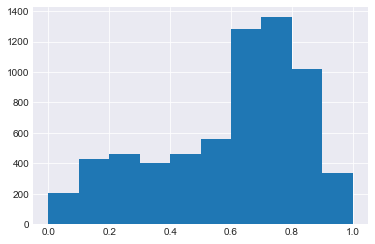

In [75]:
df_factors['MinimumWage'].hist()

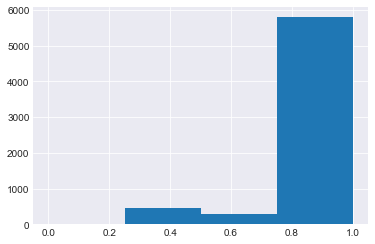

In [77]:
df_factors['Mask3_Like it\'s facing towards you, so that the tip of its nose is closest to you'].hist(bins=4)

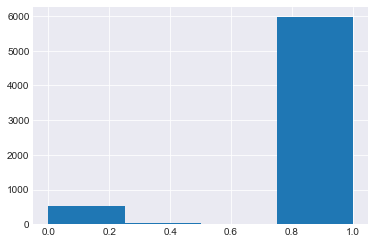

In [78]:
df_factors['Gender_M (cisgender)'].hist(bins=4)

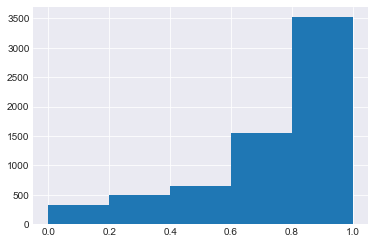

In [79]:
df_factors['ReligiousDenomination_Other'].hist(bins=5)

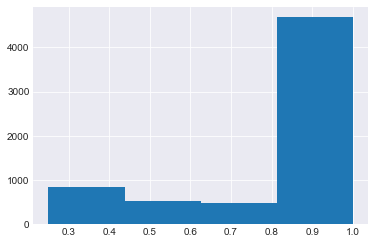

In [80]:
df_factors['SSCChangeMind_Other'].hist(bins=4)